In [101]:
import pandas as pd
import numpy as np
df = pd.read_csv('slr_processed.csv', index_col = [0])
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Year,Month,Jibe Ali (mm),Umm Sugeim (mm),Memzer (mm),Dhaw Wharfage (mm),Al Jadaf (mm)
0,2004-01-31,2004,1,2.311899,2.755406,1.703549,2.846301,2.765900
1,2004-02-29,2004,2,2.328817,2.775569,1.716015,2.867129,2.786140
2,2004-03-31,2004,3,2.325260,2.771330,1.713394,2.862750,2.781884
3,2004-04-30,2004,4,2.365526,2.812167,1.735703,2.945333,2.852154
4,2004-05-31,2004,5,2.438600,2.911484,1.803511,3.002697,2.942095
...,...,...,...,...,...,...,...,...
187,2019-08-31,2019,8,3.379349,2.089449,2.412570,3.321088,3.572494
188,2019-09-30,2019,9,3.504983,2.118592,2.433358,3.354272,3.650381
189,2019-10-31,2019,10,3.572053,2.134695,2.441854,3.373281,3.689093
190,2019-11-30,2019,11,3.597562,2.141418,2.442230,3.381930,3.700670


In [102]:
df_dhaw = df[['Date','Dhaw Wharfage (mm)']]

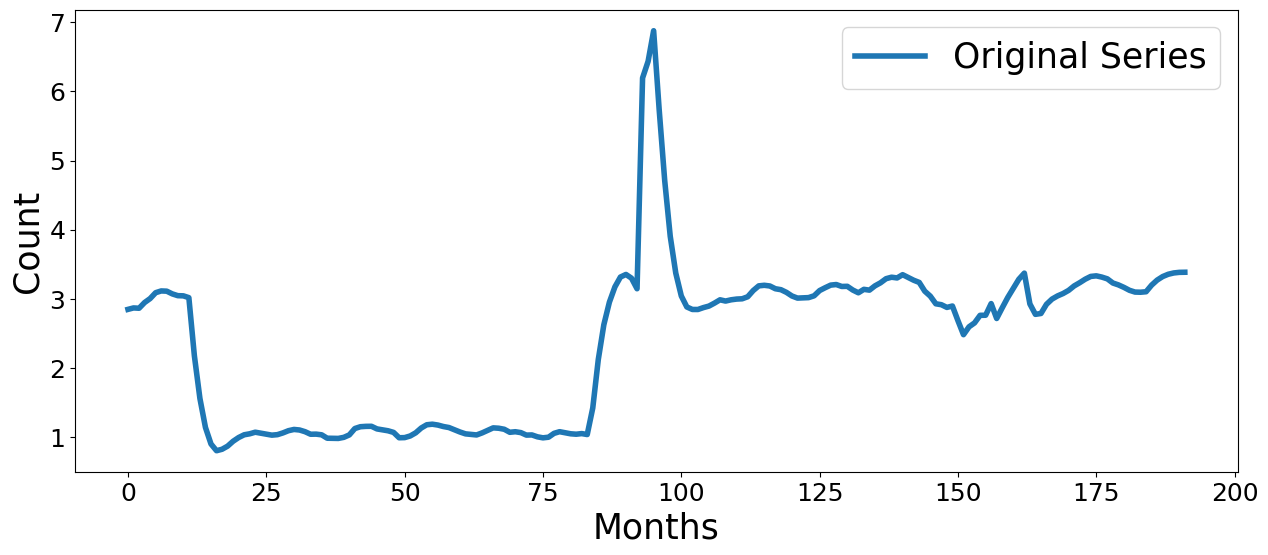

In [103]:
from matplotlib import pyplot as plt
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)
plt.plot(df['Dhaw Wharfage (mm)'], linewidth = 4, label = "Original Series")
plt.legend(fontsize=25)
plt.xlabel('Months', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
plt.show()

In [159]:
# 12*6

72

In [179]:
import pandas as pd
history = 12 #last values used by model
future = 5 #predict future values

def Tranform_dataset(input_length, output_length, data):    
    df = data.copy()
    #x columns
    i = 0
    while i < input_length:
        df[f'x_{i}'] = df['Dhaw Wharfage (mm)'].shift(-i)
        i = i + 1
   
    #y columns
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['Dhaw Wharfage (mm)'].shift(-output_length-j)
        j = j + 1
    
    #drop last columns which might have NAN
    df = df.dropna(axis=0)
    return df

full_data = Tranform_dataset(history, future, df_dhaw)
full_data.head(3)

,Date,Dhaw Wharfage (mm),x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,y_0,y_1,y_2,y_3,y_4
0,2004-01-31,2.846301,2.846301,2.867129,2.862750,2.945333,3.002697,3.087750,3.112921,3.109634,3.070565,3.044663,3.042110,3.016038,3.087750,3.112921,3.109634,3.070565,3.044663
1,2004-02-29,2.867129,2.867129,2.862750,2.945333,3.002697,3.087750,3.112921,3.109634,3.070565,3.044663,3.042110,3.016038,2.173104,3.112921,3.109634,3.070565,3.044663,3.042110
2,2004-03-31,2.862750,2.862750,2.945333,3.002697,3.087750,3.112921,3.109634,3.070565,3.044663,3.042110,3.016038,2.173104,1.556536,3.109634,3.070565,3.044663,3.042110,3.016038


In [180]:
X_cols = [col for col in full_data.columns if col.startswith('x')]

y_cols = [col for col in full_data.columns if col.startswith('y')]
X = full_data[X_cols].values
y = full_data[y_cols].values

print(X.shape, y.shape)

(181, 12) (181, 5)


In [181]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

X_train = X_train.reshape(X_train.shape[0], history, 1)
X_test = X_test.reshape(X_test.shape[0], history, 1)
print(X_train.shape, X_test.shape)

(144, 12, 1) (37, 12, 1)


In [182]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, Conv1D
tf.random.set_seed(0)

def get_model_cnn_lstm(history, future):
    model = Sequential()
    model.add(tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=5, activation='relu'))
    model.add(LSTM(6, return_sequences=True, activation='relu'))
    model.add(LSTM(6, return_sequences=False, activation='relu'))
    model.add(Dense(future))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model_cnnlstm = get_model_cnn_lstm(history, future)
model_cnnlstm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 8, 6)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 8, 6)                │             312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 6)                   │             312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │              35 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 695 (2.71 KB)

 Trainable params: 695 (2.71 KB)

 Non-trainable params: 0 (0.00 B)

In [183]:
filepath = 'CNN_LSTM2.keras'
checkpoint_cnn_lstm = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')
callbacks_cnn_lstm = [checkpoint_cnn_lstm]

hist_cnn_lstm = model_cnnlstm.fit(X_train, y_train, epochs=2000, batch_size=16, verbose=0, validation_data=(X_test, y_test), 
                 shuffle=True, callbacks = callbacks_cnn_lstm)

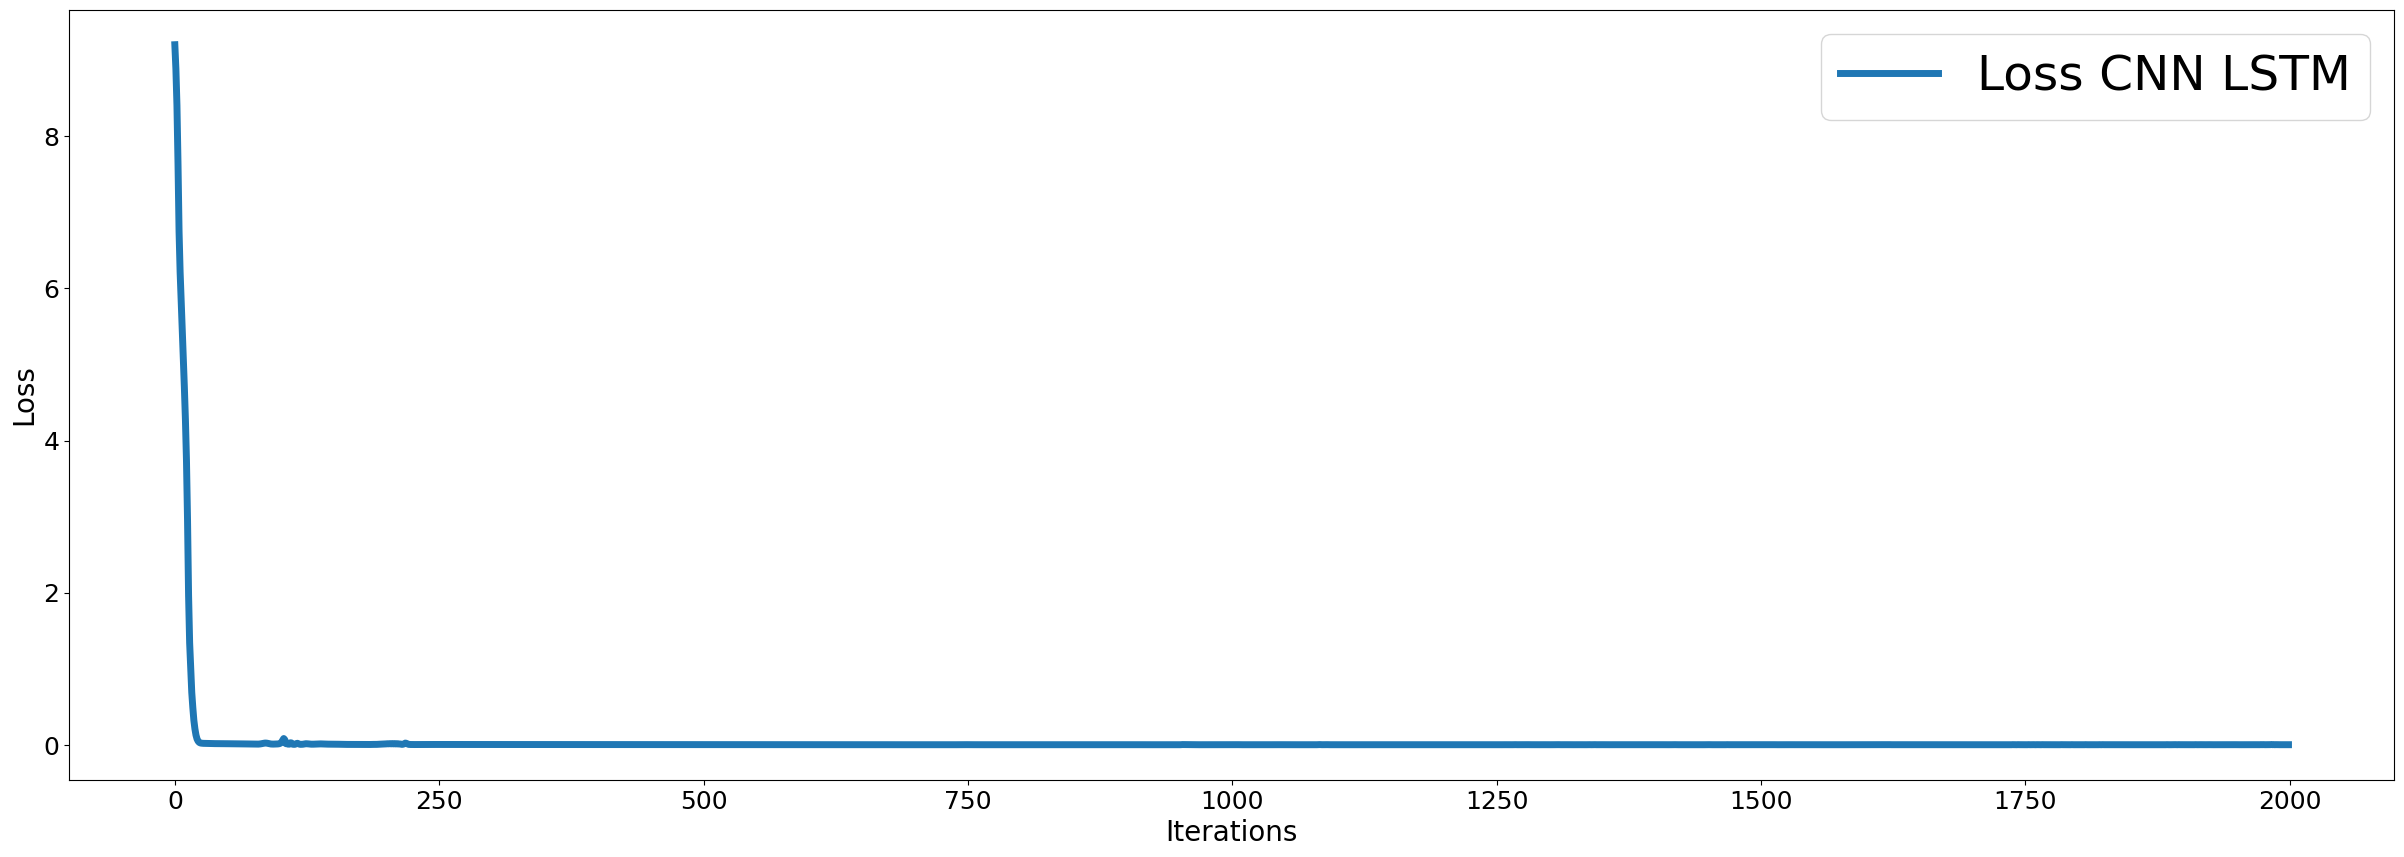

In [184]:
from matplotlib import pyplot as plt
import numpy as np 

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})

plt.plot(hist_cnn_lstm.history['val_loss'], label = "Loss CNN LSTM", lw=5)

plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)

plt.legend(fontsize = 35)
plt.show()

In [ ]:
Dhaw Wharfage

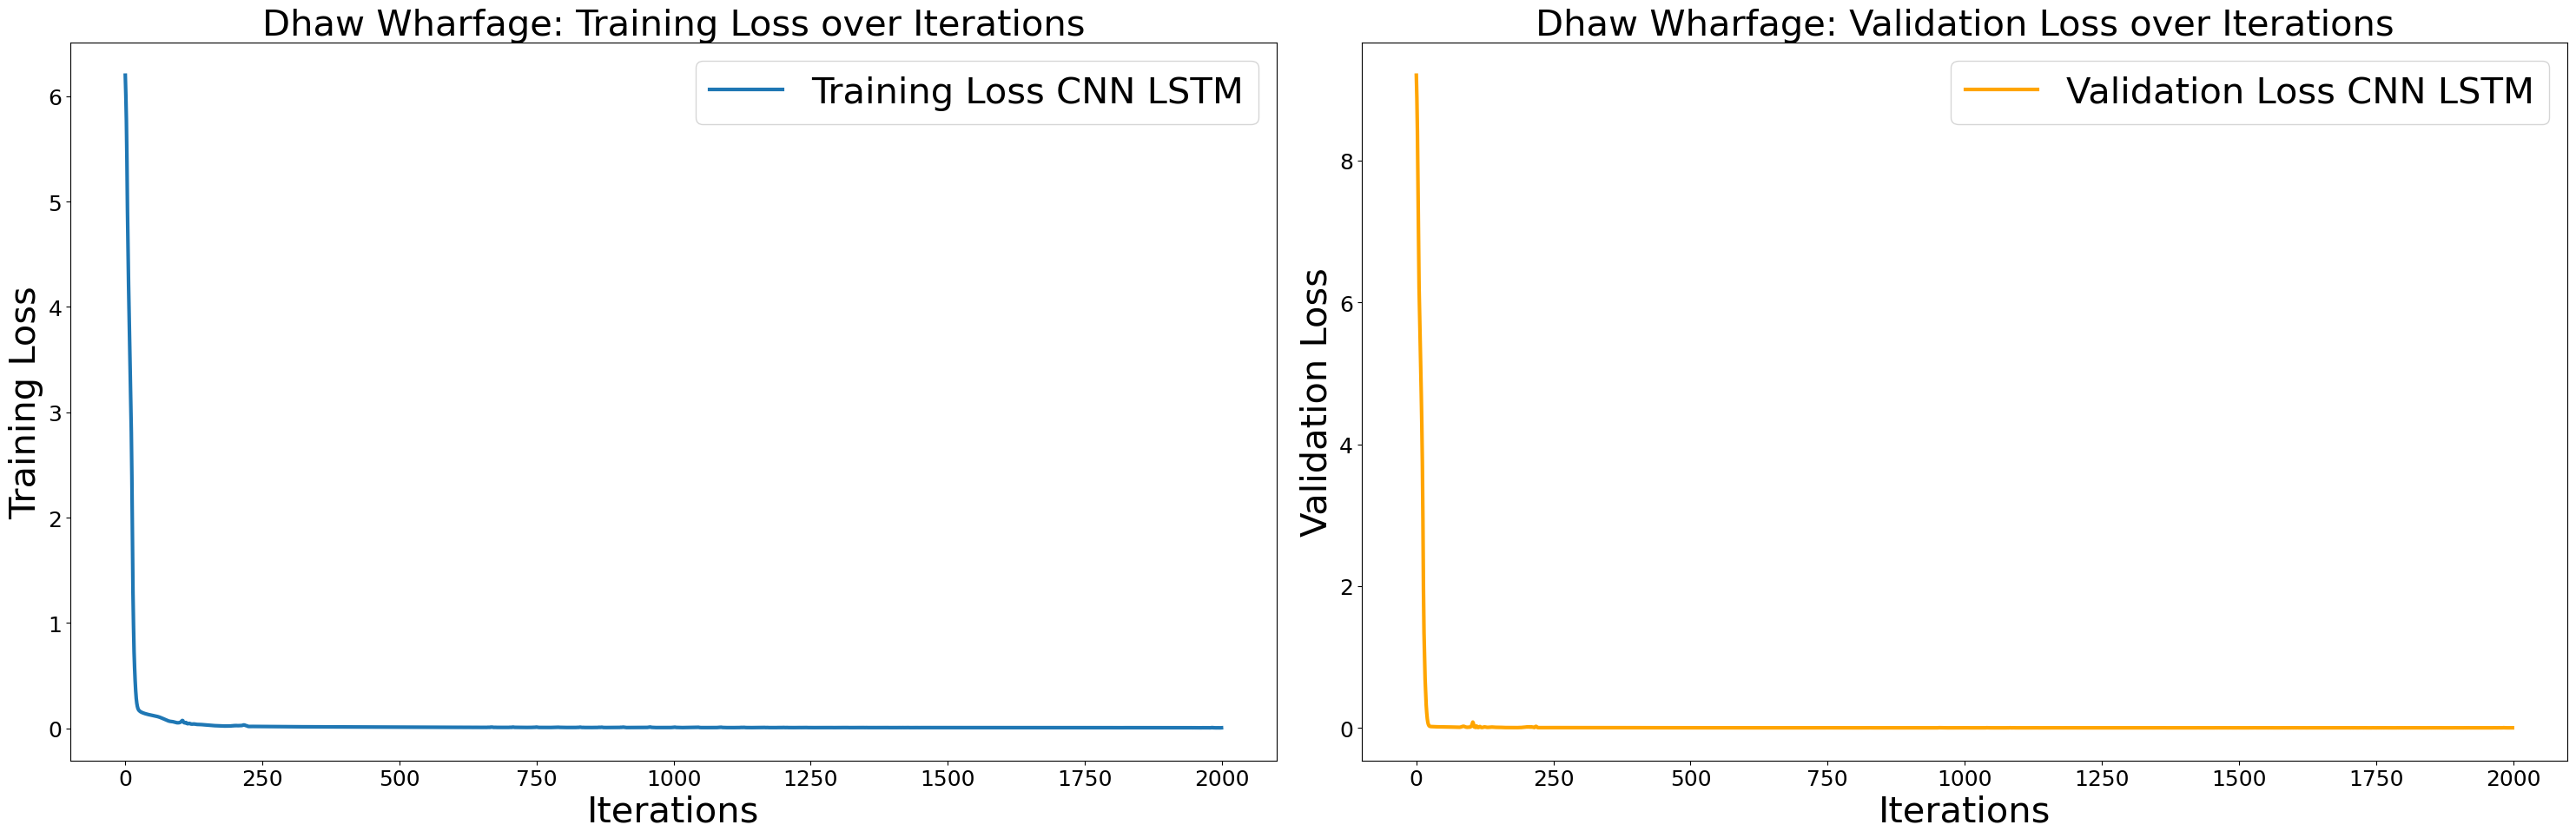

[0.004426955245435238]


[0.0029096619691699743]

In [240]:
from matplotlib import pyplot as plt

figsize = (15, 5)
fontsize = 30
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))  # Two plots side by side

# Plotting the training loss on the first subplot
ax1.plot(hist_cnn_lstm.history['loss'], label='Training Loss CNN LSTM', lw=3)
ax1.set_xlabel("Iterations", fontsize=fontsize)
ax1.set_ylabel("Training Loss", fontsize=fontsize)
ax1.set_title("Dhaw Wharfage: Training Loss over Iterations", fontsize=fontsize)
ax1.legend(fontsize=fontsize)

# Plotting the validation loss on the second subplot
ax2.plot(hist_cnn_lstm.history['val_loss'], label='Validation Loss CNN LSTM', lw=3, color='orange')
ax2.set_xlabel("Iterations", fontsize=fontsize)
ax2.set_ylabel("Validation Loss", fontsize=fontsize)
ax2.set_title("Dhaw Wharfage: Validation Loss over Iterations", fontsize=fontsize)
ax2.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()

print(hist_cnn_lstm.history['loss'][-1:])
hist_cnn_lstm.history['val_loss'][-1:]

In [235]:
hist_cnn_lstm.history['loss'][-1:]

[0.004426955245435238]

In [185]:
model_cnnlstm.load_weights('CNN_LSTM2.keras')

In [186]:
y_pred_cnn_lstm = model_cnnlstm.predict(X.reshape(X.shape[0], history, 1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


In [187]:
len(y_pred_cnn_lstm)

181

In [188]:
pred_cnn_lstm = []

truth = []

for i in range(len(y_pred_cnn_lstm)):
    if i==(len(y_pred_cnn_lstm)-1):
        for j in range(len(y_pred_cnn_lstm[i])):
            pred_cnn_lstm.append(y_pred_cnn_lstm[i][j])
            truth.append(y[i][j])    
    else:
        pred_cnn_lstm.append(y_pred_cnn_lstm[i][0])
        truth.append(y[i][0])

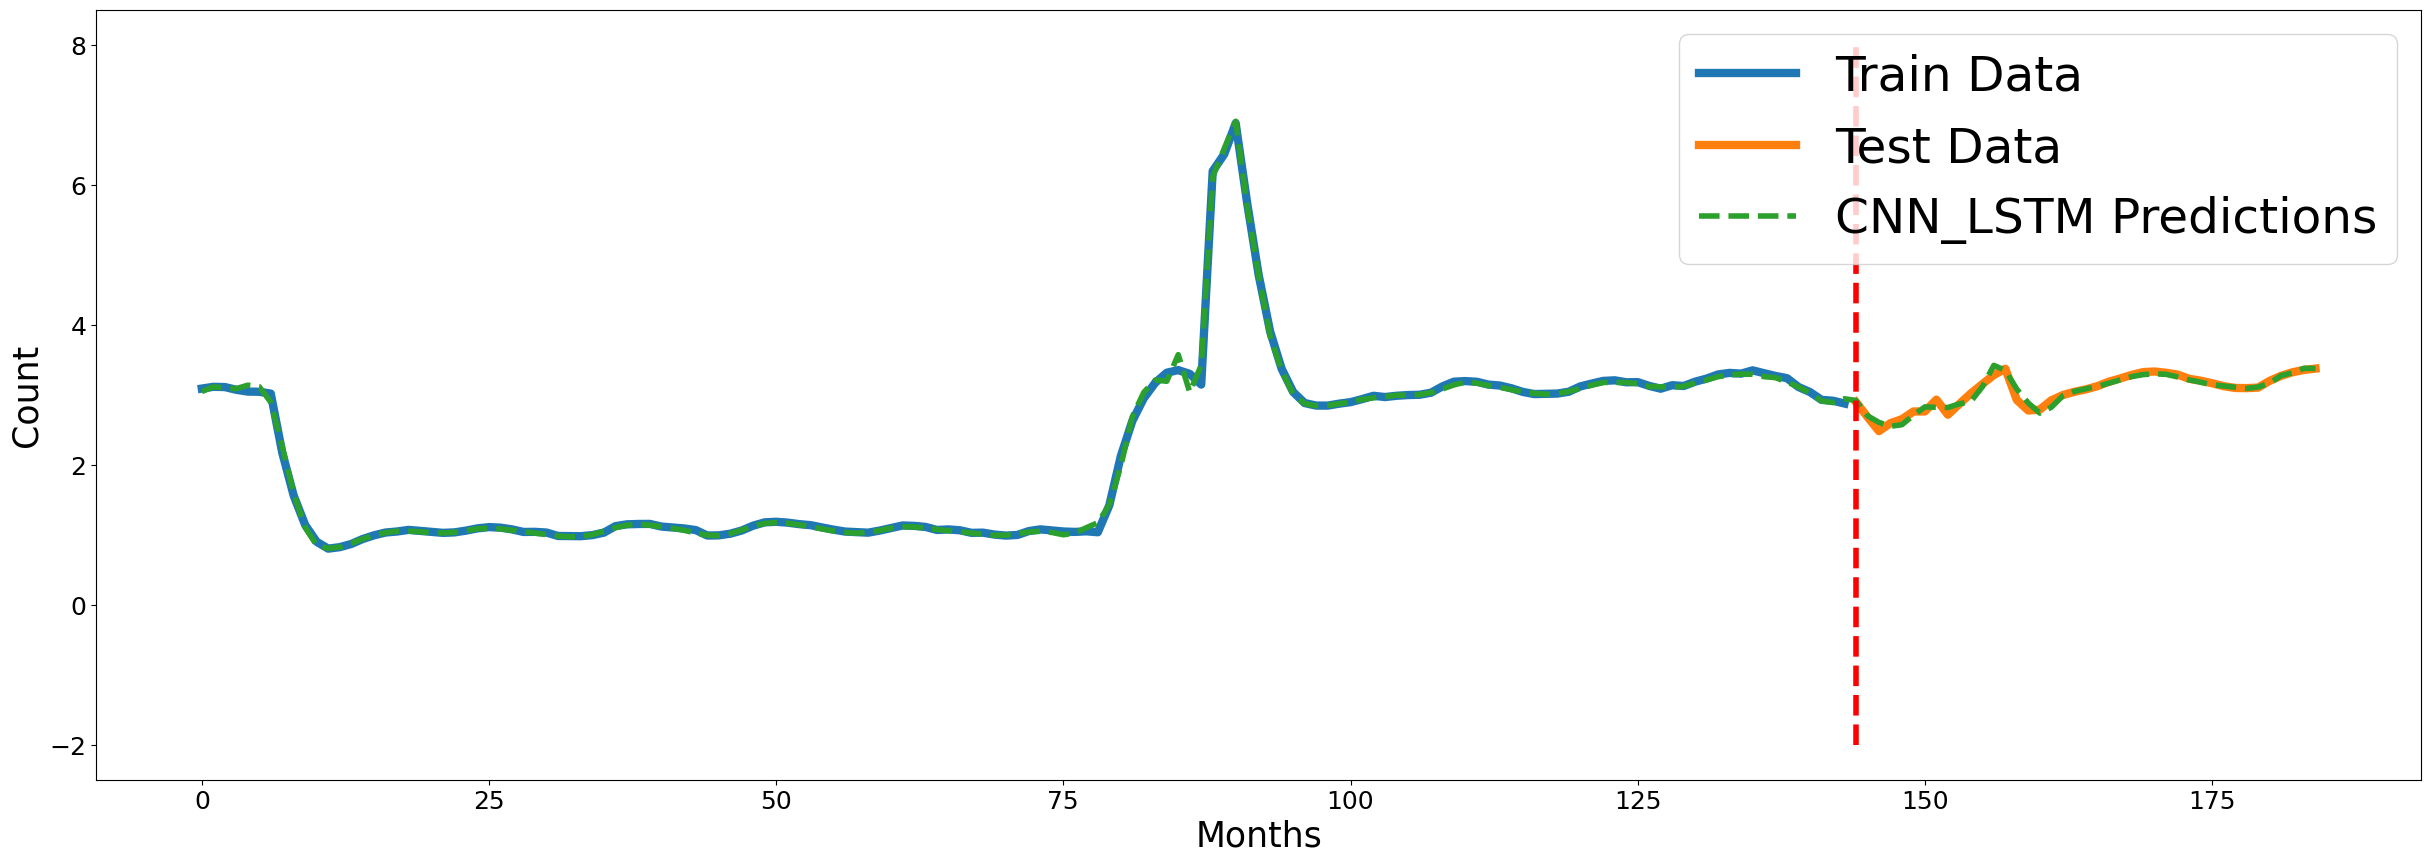

In [189]:
from matplotlib import pyplot as plt
import numpy as np 

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})

months = [i for i in range(len(truth))]

plt.plot(months[0:len(y_train)], truth[0:len(y_train)],label='Train Data', lw=6)
plt.plot(months[len(y_train):], truth[len(y_train):],label='Test Data', lw=6)

plt.plot(pred_cnn_lstm,label='CNN_LSTM Predictions', lw=4, linestyle='dashed')


plt.vlines(x=len(y_train), ymin=-2, ymax = 8, lw=4, linestyle='dashed', color='r')

plt.xlabel('Months', fontsize = 25)
plt.ylabel('Count', fontsize = 25)

plt.legend(fontsize = 35)
plt.show()

In [190]:
# len(pred_cnn_lstm)

185

In [191]:
# 2*10

20

In [81]:
# X.reshape(X.shape[0], history, 1)[:2]

array([[[2.84630136],
        [2.86712949],
        [2.86275016],
        [2.94533317],
        [3.00269705],
        [3.08775004],
        [3.11292148],
        [3.109634  ],
        [3.07056469],
        [3.04466308],
        [3.0421104 ],
        [3.01603778]],

       [[2.86712949],
        [2.86275016],
        [2.94533317],
        [3.00269705],
        [3.08775004],
        [3.11292148],
        [3.109634  ],
        [3.07056469],
        [3.04466308],
        [3.0421104 ],
        [3.01603778],
        [2.17310373]]])

In [79]:
# df_dhaw['Dhaw Wharfage (mm)'][-12:].values.reshape(-1,12,1)

array([[[3.16431631],
        [3.12224623],
        [3.09668323],
        [3.09442287],
        [3.10148711],
        [3.19720006],
        [3.26983366],
        [3.32108785],
        [3.35427228],
        [3.37328122],
        [3.3819299 ],
        [3.38357428]]])

In [192]:
window_ = df_dhaw['Dhaw Wharfage (mm)'][-12:].values.reshape(-1,12,1)
make_pred = model_cnnlstm.predict(window_)
make_pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


(1, 5)

In [221]:
pred = []
data = df_dhaw.copy()
def generate_future_dates(start_date, periods):
    return pd.date_range(start=start_date, periods=periods, freq='M')
for i in range(27):
    window_ = data['Dhaw Wharfage (mm)'][-12:].values.reshape(-1,12,1)
    make_pred = model_cnnlstm.predict(window_).flatten()
    pred.extend(make_pred)
    last_date = data['Date'].iloc[-1]
    future_dates = generate_future_dates(last_date, 6)[1:]
    pred_df = pd.DataFrame({
        'Date': future_dates,
        'Dhaw Wharfage (mm)': make_pred
    })
    data = pd.concat([data, pred_df], ignore_index=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

In [196]:
# pred = []
# data = df_dhaw.copy()
# def generate_future_dates(start_date, periods):
#     return pd.date_range(start=start_date, periods=periods, freq='M')
# for i in range(120):
#     window_ = data['Dhaw Wharfage (mm)'][-12:].values.reshape(-1,12,1)
#     make_pred = model_cnnlstm.predict(window_).flatten()
#     pred.extend(make_pred)
#     future_date = data['Date'].iloc[-1] + pd.DateOffset(months=1)
#     pred_df = pd.DataFrame({
#         'Date': [future_date],
#         'Dhaw Wharfage (mm)': make_pred
#     })
#     data = pd.concat([data, pred_df], ignore_index=True)

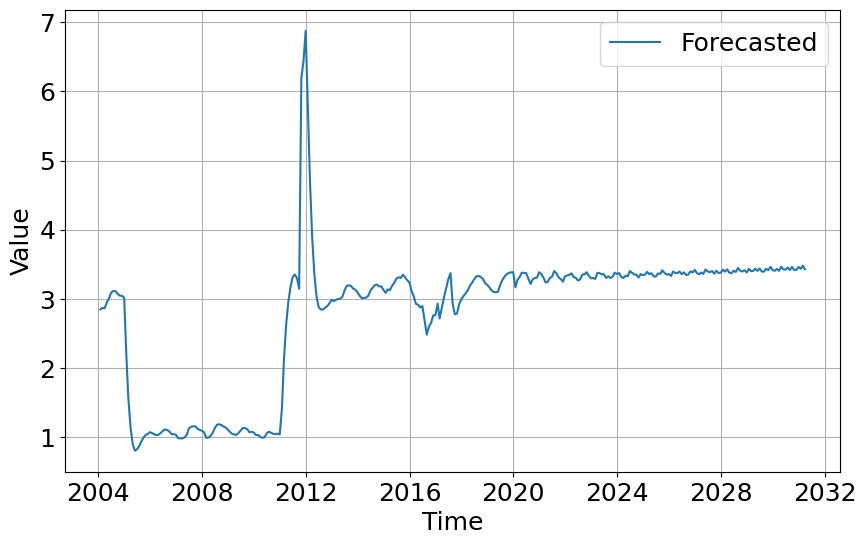

In [222]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend()
    plt.grid(True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_series(data['Date'], data['Dhaw Wharfage (mm)'], label='Forecasted')
plt.show()

In [225]:
import numpy as np
import pandas as pd

data['Year'] = data['Date'].dt.year

# Calculate annual average sea level
annual_avg = data.groupby('Year')['Dhaw Wharfage (mm)'].mean().reset_index()
annual_avg['Yearly Increase (mm)'] = annual_avg['Dhaw Wharfage (mm)'].diff()

# Calculate the average annual increase 
average_annual_increase = annual_avg['Yearly Increase (mm)'][1:].mean()

print(f'Average Annual Increase in Sea Level: {average_annual_increase:} mm/year')


Average Annual Increase in Sea Level: 0.016504369938802586 mm/year


In [226]:
data2 = data.copy()
data2 = data2[data2['Year'] >2019]
annual_avg = data2.groupby('Year')['Dhaw Wharfage (mm)'].mean().reset_index()
annual_avg['Yearly Increase (mm)'] = annual_avg['Dhaw Wharfage (mm)'].diff()

# Calculate the average annual increase 
average_annual_increase = annual_avg['Yearly Increase (mm)'][1:].mean()

print(f'Average Annual Increase in Sea Level: {average_annual_increase:} mm/year')

Average Annual Increase in Sea Level: 0.012889730207847812 mm/year


In [239]:
data.to_csv("dhawwharfage.csv")

In [238]:
data

,Date,Dhaw Wharfage (mm),Year
0,2004-01-31,2.846301,2004
1,2004-02-29,2.867129,2004
2,2004-03-31,2.862750,2004
3,2004-04-30,2.945333,2004
4,2004-05-31,3.002697,2004
...,...,...,...
322,2030-11-30,3.417571,2030
323,2030-12-31,3.459735,2030
324,2031-01-31,3.432856,2031
325,2031-02-28,3.478049,2031


In [241]:
annual_avg

,Year,Dhaw Wharfage (mm),Yearly Increase (mm)
0,2020,3.304489,NaN
1,2021,3.308354,0.003865
2,2022,3.326829,0.018476
3,2023,3.335088,0.008259
4,2024,3.344211,0.009123
5,2025,3.360274,0.016063
6,2026,3.373920,0.013646
7,2027,3.382004,0.008084
8,2028,3.401334,0.019330
9,2029,3.418643,0.017309


In [242]:
from scipy import stats
residuals = np.array(truth) - np.array(pred_cnn_lstm)
std_dev = np.std(residuals, ddof=1)  
n = len(truth)
standard_error = std_dev / np.sqrt(n)

print(f"Standard Error: {standard_error}")

Standard Error: 0.003872725478040814


In [243]:
model_cnnlstm.save("FINAL_DhawWharfage.keras")